In [5]:
# import torch
# import torch.nn as nn
# from torch import optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision import ops
# from torchvision.utils import make_grid

from tqdm.notebook import tqdm

import numpy as np
import cv2
from glob import glob
import albumentations as A

import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

In [11]:
## CAMERA CALIBRATION

In [12]:
images = []
for image in glob('calibration/thermal/*.png'):
    images.append(cv2.imread(image, cv2.IMREAD_GRAYSCALE))  # h x w
images = np.array(images)  # n x h x w

In [13]:
def show_images(images: np.ndarray, mask: np.ndarray = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    if mask is not None:  # k,
        images = images[mask, ...]  # k x h x w
    images = torch.as_tensor(images).unsqueeze(1)  # n(k) x 1 x h x w
    grid = make_grid(images, nrow=int(np.sqrt(images.size(0))))  # 3 x h x w
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    

def show_image(image: np.ndarray, cmap: str = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

In [14]:
# checkerboard is of grid type (8, 7), as a convention
# the longer side is considered the width of the board
grid = (8, 7)
square_size = 50  # mm

In [15]:
def search_for_corners(images, grid, invert=False) -> Tuple[np.array, np.ndarray]:
    found_corners = []
    mask = []
    for image in tqdm(images):
        if invert:
            image = -image + 255
        found, corners = cv2.findChessboardCorners(image, grid)
        mask.append(found)
        if found:  # refine corners on subpixel level
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners = cv2.cornerSubPix(image, corners, (11, 11), (-1, -1), criteria)
            found_corners.append(corners)
    return np.array(mask), np.array(found_corners)

In [19]:
mask, found_corners = search_for_corners(images, grid, invert=True)

In [27]:
# Check if calibration failed complety
assert (mask == 1).any()

In [28]:
image_points = found_corners  # 2d points in image plane
# 3d point in real world space, z coordinates will stay 0
world_points = np.zeros((*found_corners.shape[:2], 3), 
    dtype=found_corners.dtype)
# create xy world points
xy = square_size * np.mgrid[:grid[0],:grid[1]].T.reshape(-1, 2)
world_points[..., :2] = xy

In [30]:
image_shape = images.shape[-2:]
image_shape  # height, width

(512, 640)

In [31]:
err, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(world_points, 
    image_points, image_shape, None, None)

In [32]:
Rmats_v1 = [cv2.Rodrigues(r)[0] for r in rvecs]
Rmats_v1[0]

array([[-0.86862416,  0.36811353,  0.3316391 ],
       [-0.20959342, -0.87949799,  0.42726325],
       [ 0.4489573 ,  0.3016218 ,  0.84110738]])

In [10]:
## IMAGE PREPROCESSING

In [6]:
def show_images(images: np.ndarray, mask: np.ndarray = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    if mask is not None:  # k,
        images = images[mask, ...]  # k x h x w
    images = torch.as_tensor(images).unsqueeze(1)  # n(k) x 1 x h x w
    grid = make_grid(images, nrow=int(np.sqrt(images.size(0))))  # 3 x h x w
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    

def show_image(image: np.ndarray, cmap: str = None, figsize=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

In [7]:
# display multiple images of a line
files = sorted(glob('./data/F6/Images/4/*.tiff', recursive=False))
label = json.load(open('./data/F6/Labels/Label4.json', 'rb'))
pose = json.load(open('./data/F6/Poses/4.json', 'rb'))

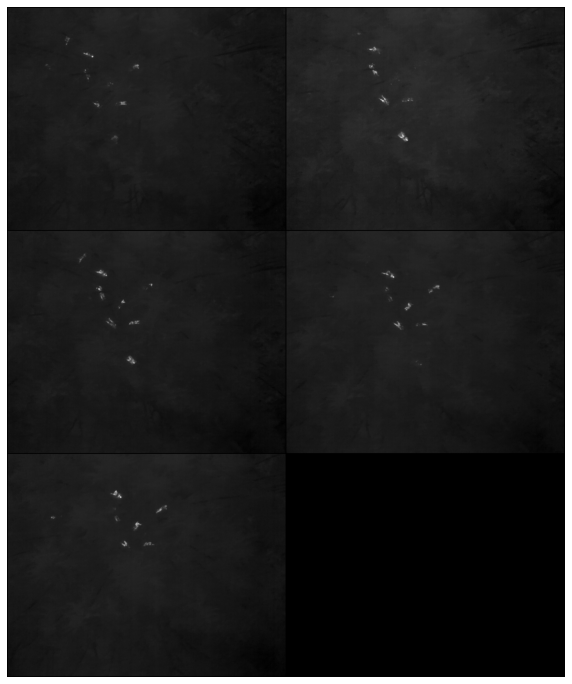

In [8]:
def imread(files: List[str], undistort=False):
    images = []
    for path in files:
        image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
        image = cv2.normalize(image, dst=None, alpha=0, beta=2**16 - 1, 
            norm_type=cv2.NORM_MINMAX)
        image = (image >> 8).astype(np.uint8)  # 8 bit image
        if undistort:  # undistort camera images
            h, w = image.shape
            # returns the new camera intrinsic matrix based 
            # on the free scaling parameter
            refined_K, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, 
                (w, h), 1, (w, h))
            x, y, w, h = roi
            image = image[y:y+h, x:x+w]
            image = cv2.undistort(image, K, dist_coeffs, None, refined_K)
        images.append(image)
    images = np.array(images)  # n x h x w
    return images
    

images = imread(files, undistort=False)
image_ids = list(range(13, 18))
show_images(images[image_ids], figsize=(10, 15))

In [9]:
def integrate(images: np.ndarray, win: List[int], K: np.ndarray, 
    M: np.ndarray, z: float, verbose=False):
    """ win ... window of integration """
    h, w = images.shape[1:]  # gray scale images
    integral = np.zeros((h, w), np.float64)
    _images = images[win]
    _M = M[win]
    count = len(win)
    
    # center index
    idc = len(_images) // 2
    
    # invese of the intrinsic mapping
    K_inv = np.linalg.inv(K)
    
    # M = ( A b ) or M = K ( R t )
    Mc = _M[idc]  # 3 x 4

    # the given M matrices seem to consist solely of ( R t ) part
    Rc = Mc[:, :3]  # 3 x 3
    tc = Mc[:, 3:]  # 3 x 1

    for i in range(len(_images)):
        if i != idc:
            Mr = _M[i]  # 3 x 4
            Rr = Mr[:, :3]  # 3 x 3
            tr = Mr[:, 3:]  # 3 x 1

            # relative translation and rotation
            R_ = Rc @ Rr.T  # 3 x 3
            t_ = tc - R_ @ tr  # 3 x 1

            B = K @ R_ @ K_inv
            B[:, 2:] += K @ t_ / z
            warped = cv2.warpPerspective(_images[i], B, (w, h))
            if verbose:
                show_image(warped, cmap='gray')
            integral += warped
        else:
            if verbose:
                show_image(_images[i], cmap='gray')
            integral += _images[i]

    integral /= count
    integral = cv2.normalize(integral, None, 
        0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return integral  # 8bit gray scale integral image 


z = 30  # m
integral = integrate(images, image_ids, K, M, z, verbose=True)
show_image(integral, cmap='gray', figsize=(10, 15))

NameError: name 'K' is not defined